# DSCI 100: Group Project Proposal 


## Classification of Facebook Posts

#### Introduction:

The dataset *Facebook performance metrics* (Moro et al., 2016) contains data related to posts published throughout the year 2014 on a renowned cosmetics brand's Facebook page. Post information such as type (photo, status, link, or video), time posted (month, day of week, and hour), user engagement (comments, likes, and shares), and whether the post was paid or unpaid is included in the dataset. This project proposes to use columns from this dataset relevant to engagement - all input columns excluding post month, weekday, and hour - to determine the type of a brand's Facebook post. Key metrics and their correlation with type of post will be investigated to determine whether there is a relationship between the two. 


# EXPLICITELY STATE OUR RESEARCH QUESTION HERE!!!
**from proposal feedback, Please state your proposal question clearly and in a form of a "predictive question"**

#### Preliminary exploratory data analysis:

We begin by loading the relevant libraries.

In [8]:
# Load libraries for preliminary data analysis:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(GGally)

The following cell loads the dataset into R; as the dataset on the web is contained in a zip folder, the .csv file was manually extracted and pushed to the working Github repository.

The dataset is already in tidy format. The column headings were made more usable by removing spaces and shortening longer headings.

In [9]:
# displays first and last 8 rows of the dataset
options(repr.matrix.max.rows = 16)
# Set the seed
set.seed(123)

# Load the data in
fb_data_raw <- read_csv2("https://gist.githubusercontent.com/KolCrooks/691e5890b6747b4777d6032f019b2c0f/raw/20629a5da3d5a7683e3071798876f3e4b204fbbb/fb_data.csv",  col_types = cols())

fb_data_raw

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186
139441,Photo,3,12,1,3,1,11692,19479,481,265,364,15432,9328,379,3,249,27,279
139441,Photo,3,12,7,9,1,13720,24137,537,232,305,19728,11056,422,0,325,14,339
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [10]:
# Na Rows:
sum(is.na(fb_data_raw))

[1] 6

# EXPLAIN WHY WE CONVERT COMMENT LIKE AND SHARE TO PERCENTS

In [11]:
# Clean the data:
fb_data_clean_cols <- fb_data_raw
colnames(fb_data_clean_cols) <- c("page_likes", "type", "category", "post_month", "post_weekday", "post_hour", "paid", "reach", 
      "impressions", "engaged_users", "post_consumers", "post_consumptions", "impressions_by_people_that_liked_page", 
      "reach_by_people_that_like_page", "people_liked_and_engaged", "comments", "likes", "shares", "interactions")
fb_data_clean <- fb_data_clean_cols %>% 
        mutate(type = as_factor(type)) %>% 
        mutate(category = as_factor(category)) %>% 
        mutate(post_month = as_factor(post_month)) %>% 
        mutate(post_weekday = as_factor(post_weekday)) %>% 
        mutate(post_hour = as_factor(post_hour)) %>% 
        mutate(comment_percent = comments / interactions) %>% 
        mutate(like_percent = likes / interactions) %>% 
        mutate(share_percent = shares / interactions) %>% 
        na.omit()

fb_data_clean

page_likes,type,category,post_month,post_weekday,post_hour,paid,reach,impressions,engaged_users,⋯,impressions_by_people_that_liked_page,reach_by_people_that_like_page,people_liked_and_engaged,comments,likes,shares,interactions,comment_percent,like_percent,share_percent
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,⋯,3078,1640,119,4,79,17,100,0.040000000,0.7900000,0.17000000
139441,Status,2,12,3,10,0,10460,19057,1457,⋯,11710,6112,1108,5,130,29,164,0.030487805,0.7926829,0.17682927
139441,Photo,3,12,3,3,0,2413,4373,177,⋯,2812,1503,132,0,66,14,80,0.000000000,0.8250000,0.17500000
139441,Photo,2,12,2,10,1,50128,87991,2211,⋯,61027,32048,1386,58,1572,147,1777,0.032639280,0.8846370,0.08272369
139441,Photo,2,12,2,3,0,7244,13594,671,⋯,6228,3200,396,19,325,49,393,0.048346056,0.8269720,0.12468193
139441,Status,2,12,1,9,0,10472,20849,1191,⋯,16034,7852,1016,1,152,33,186,0.005376344,0.8172043,0.17741935
139441,Photo,3,12,1,3,1,11692,19479,481,⋯,15432,9328,379,3,249,27,279,0.010752688,0.8924731,0.09677419
139441,Photo,3,12,7,9,1,13720,24137,537,⋯,19728,11056,422,0,325,14,339,0.000000000,0.9587021,0.04129794
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [12]:
# Na Rows:
sum(is.na(fb_data_clean))

[1] 0

# EXPLAIN WHY THE STRATA IS "TYPE"
# EXPLAIN WHY WE CHOSE 75%
**"Why have you decided to use 75% of the dataset as the training data?"**

In [13]:
# Split the data:
fb_split <- initial_split(fb_data_clean, prop = 0.75, strata = type)
fb_train <- training(fb_split)
fb_test <- testing(fb_split)

fb_train

page_likes,type,category,post_month,post_weekday,post_hour,paid,reach,impressions,engaged_users,⋯,impressions_by_people_that_liked_page,reach_by_people_that_like_page,people_liked_and_engaged,comments,likes,shares,interactions,comment_percent,like_percent,share_percent
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,⋯,3078,1640,119,4,79,17,100,0.040000000,0.7900000,0.17000000
139441,Status,2,12,3,10,0,10460,19057,1457,⋯,11710,6112,1108,5,130,29,164,0.030487805,0.7926829,0.17682927
139441,Photo,3,12,3,3,0,2413,4373,177,⋯,2812,1503,132,0,66,14,80,0.000000000,0.8250000,0.17500000
139441,Status,2,12,1,9,0,10472,20849,1191,⋯,16034,7852,1016,1,152,33,186,0.005376344,0.8172043,0.17741935
139441,Photo,3,12,1,3,1,11692,19479,481,⋯,15432,9328,379,3,249,27,279,0.010752688,0.8924731,0.09677419
139441,Photo,3,12,7,9,1,13720,24137,537,⋯,19728,11056,422,0,325,14,339,0.000000000,0.9587021,0.04129794
139441,Status,2,12,7,3,0,11844,22538,1530,⋯,15220,7912,1250,0,161,31,192,0.000000000,0.8385417,0.16145833
139441,Photo,3,12,6,10,0,4694,8668,280,⋯,4309,2324,199,3,113,26,142,0.021126761,0.7957746,0.18309859
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮



##### Preliminary summary tables:

Tables were constructed to gain an initial summary of the data. Table *summary_table1* groups posts by type and computes the total posts, total interactions (including all likes, comments, shares), maximum interactions, and number of paid posts for each type.

In [14]:
summary_table1 = fb_train %>% 
    group_by(type) %>%
    summarize(
        total_of_type = n(),
        total_interactions = sum(interactions),
        max_interactions = max(interactions),
        total_paid = sum(paid))

summary_table1

`summarise()` ungrouping output (override with `.groups` argument)



type,total_of_type,total_interactions,max_interactions,total_paid
<fct>,<int>,<dbl>,<dbl>,<dbl>
Photo,316,69489,2177,92
Status,33,6489,587,6
Link,15,1437,420,5
Video,4,1404,550,3


## UPSAMPLING?
**"There is an extreme class imbalance in your dataset, how are you planning to deal with the class imbalance? (e.g. upsampling, downsampling, etc.)"**

Table *summary_table2* groups posts by type and computes the total interactions, maximum interactions, percentage of each interaction type, and percentage of paid posts for each post type. The *likes* and *shares* columns were also found to include observations with missing data, so the *na.rm = TRUE* argument was included in each.

In [15]:
summary_table2 <- fb_train %>% 
    group_by(type) %>% 
    summarize(
        total_interactions = sum(interactions),
        max_interactions = max(interactions),
        comments_interaction_percentage = (sum(comments) / sum(interactions) * 100),
        likes_interaction_percentage = (sum(likes, na.rm = TRUE) / sum(interactions) * 100),
        shares_interaction_percentage = (sum(shares, na.rm = TRUE) / sum(interactions) * 100),
        paid_percentage = (sum(paid, na.rm = TRUE) / n()) * 100)     

summary_table2

`summarise()` ungrouping output (override with `.groups` argument)



type,total_interactions,max_interactions,comments_interaction_percentage,likes_interaction_percentage,shares_interaction_percentage,paid_percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Photo,69489,2177,3.279656,84.45797,12.26237,29.11392
Status,6489,587,4.438280,80.12020,15.44152,18.18182
Link,1437,420,3.409882,82.74182,13.84830,33.33333
Video,1404,550,5.413105,79.13105,15.45584,75.00000



##### Preliminary visualizations:

The following bar chart is created to show the ratios of interaction types across each type of post.

`summarise()` ungrouping output (override with `.groups` argument)



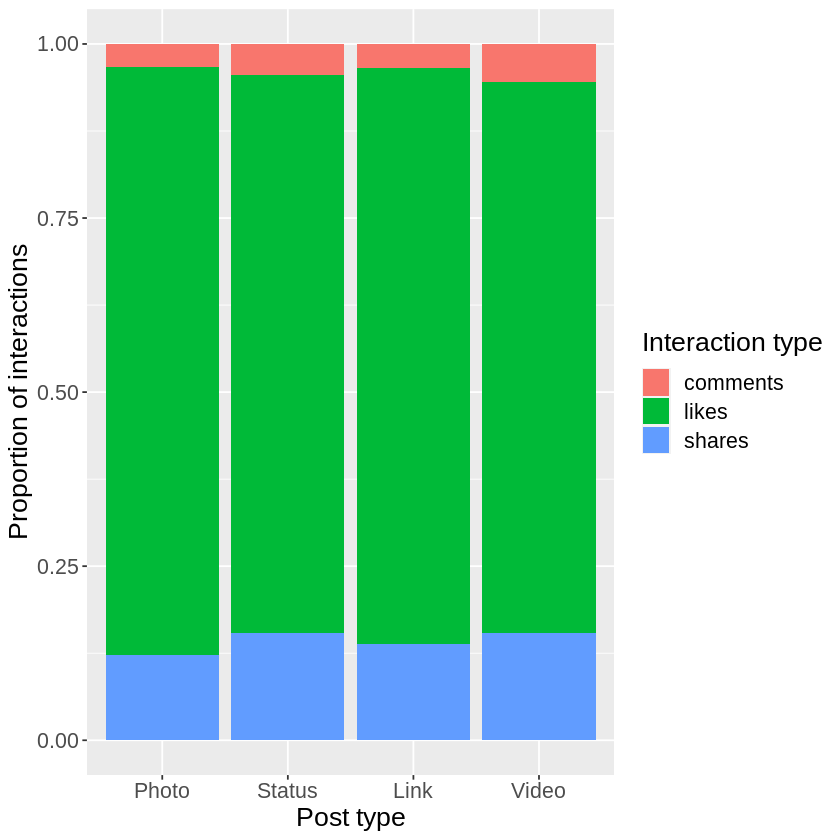

In [16]:
options(repr.plot.height = 7, repr.plot.width = 7)

relative_interactions <- fb_train %>% 
    group_by(type) %>%
    summarize(
        comments = sum(comments),
        likes = sum(likes, na.rm=TRUE),
        shares = sum(shares, na.rm=TRUE),
        total_interactions = sum(interactions)) %>% 
        pivot_longer( cols = comments:shares,
                       names_to = "interaction_type",
                       values_to = "total_of_interaction_type")

relative_interactions_plot <- ggplot(relative_interactions, aes(x = type, y = total_of_interaction_type, fill = interaction_type)) + 
        geom_bar(stat = "identity", position = "fill") + 
        xlab("Post type") +
        ylab("Proportion of interactions") +
        labs(fill = "Interaction type") +
        theme(text = element_text(size = 16))
  

relative_interactions_plot

## Polt title!
**The plot does not include a title. For the report, please make sure you are labelling your tables and plots.**

# TODO: WRITE BETTER HERE!!!
**- The choice of the predictors are not justified**

Here we will remove time based categories because blah blah blah time based stuff bad. remove category column because we can't use a factor to predict. Remove comments, likes, shares, interactions because we will now combine them into percent based ones.

In [17]:
colnames(fb_data_clean)

[1] "page_likes"                           
 [2] "type"                                 
 [3] "category"                             
 [4] "post_month"                           
 [5] "post_weekday"                         
 [6] "post_hour"                            
 [7] "paid"                                 
 [8] "reach"                                
 [9] "impressions"                          
[10] "engaged_users"                        
[11] "post_consumers"                       
[12] "post_consumptions"                    
[13] "impressions_by_people_that_liked_page"
[14] "reach_by_people_that_like_page"       
[15] "people_liked_and_engaged"             
[16] "comments"                             
[17] "likes"                                
[18] "shares"                               
[19] "interactions"                         
[20] "comment_percent"                      
[21] "like_percent"                         
[22] "share_percent"

In [18]:
fb_data_selected <- fb_data_clean %>% 
            select(-post_month, -post_weekday, -post_hour, -category, -interactions) # -comments, -likes, -shares
fb_data_selected

page_likes,type,paid,reach,impressions,engaged_users,post_consumers,post_consumptions,impressions_by_people_that_liked_page,reach_by_people_that_like_page,people_liked_and_engaged,comments,likes,shares,comment_percent,like_percent,share_percent
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,0,2752,5091,178,109,159,3078,1640,119,4,79,17,0.040000000,0.7900000,0.17000000
139441,Status,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,0.030487805,0.7926829,0.17682927
139441,Photo,0,2413,4373,177,113,154,2812,1503,132,0,66,14,0.000000000,0.8250000,0.17500000
139441,Photo,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,0.032639280,0.8846370,0.08272369
139441,Photo,0,7244,13594,671,410,580,6228,3200,396,19,325,49,0.048346056,0.8269720,0.12468193
139441,Status,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,0.005376344,0.8172043,0.17741935
139441,Photo,1,11692,19479,481,265,364,15432,9328,379,3,249,27,0.010752688,0.8924731,0.09677419
139441,Photo,1,13720,24137,537,232,305,19728,11056,422,0,325,14,0.000000000,0.9587021,0.04129794
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better valu

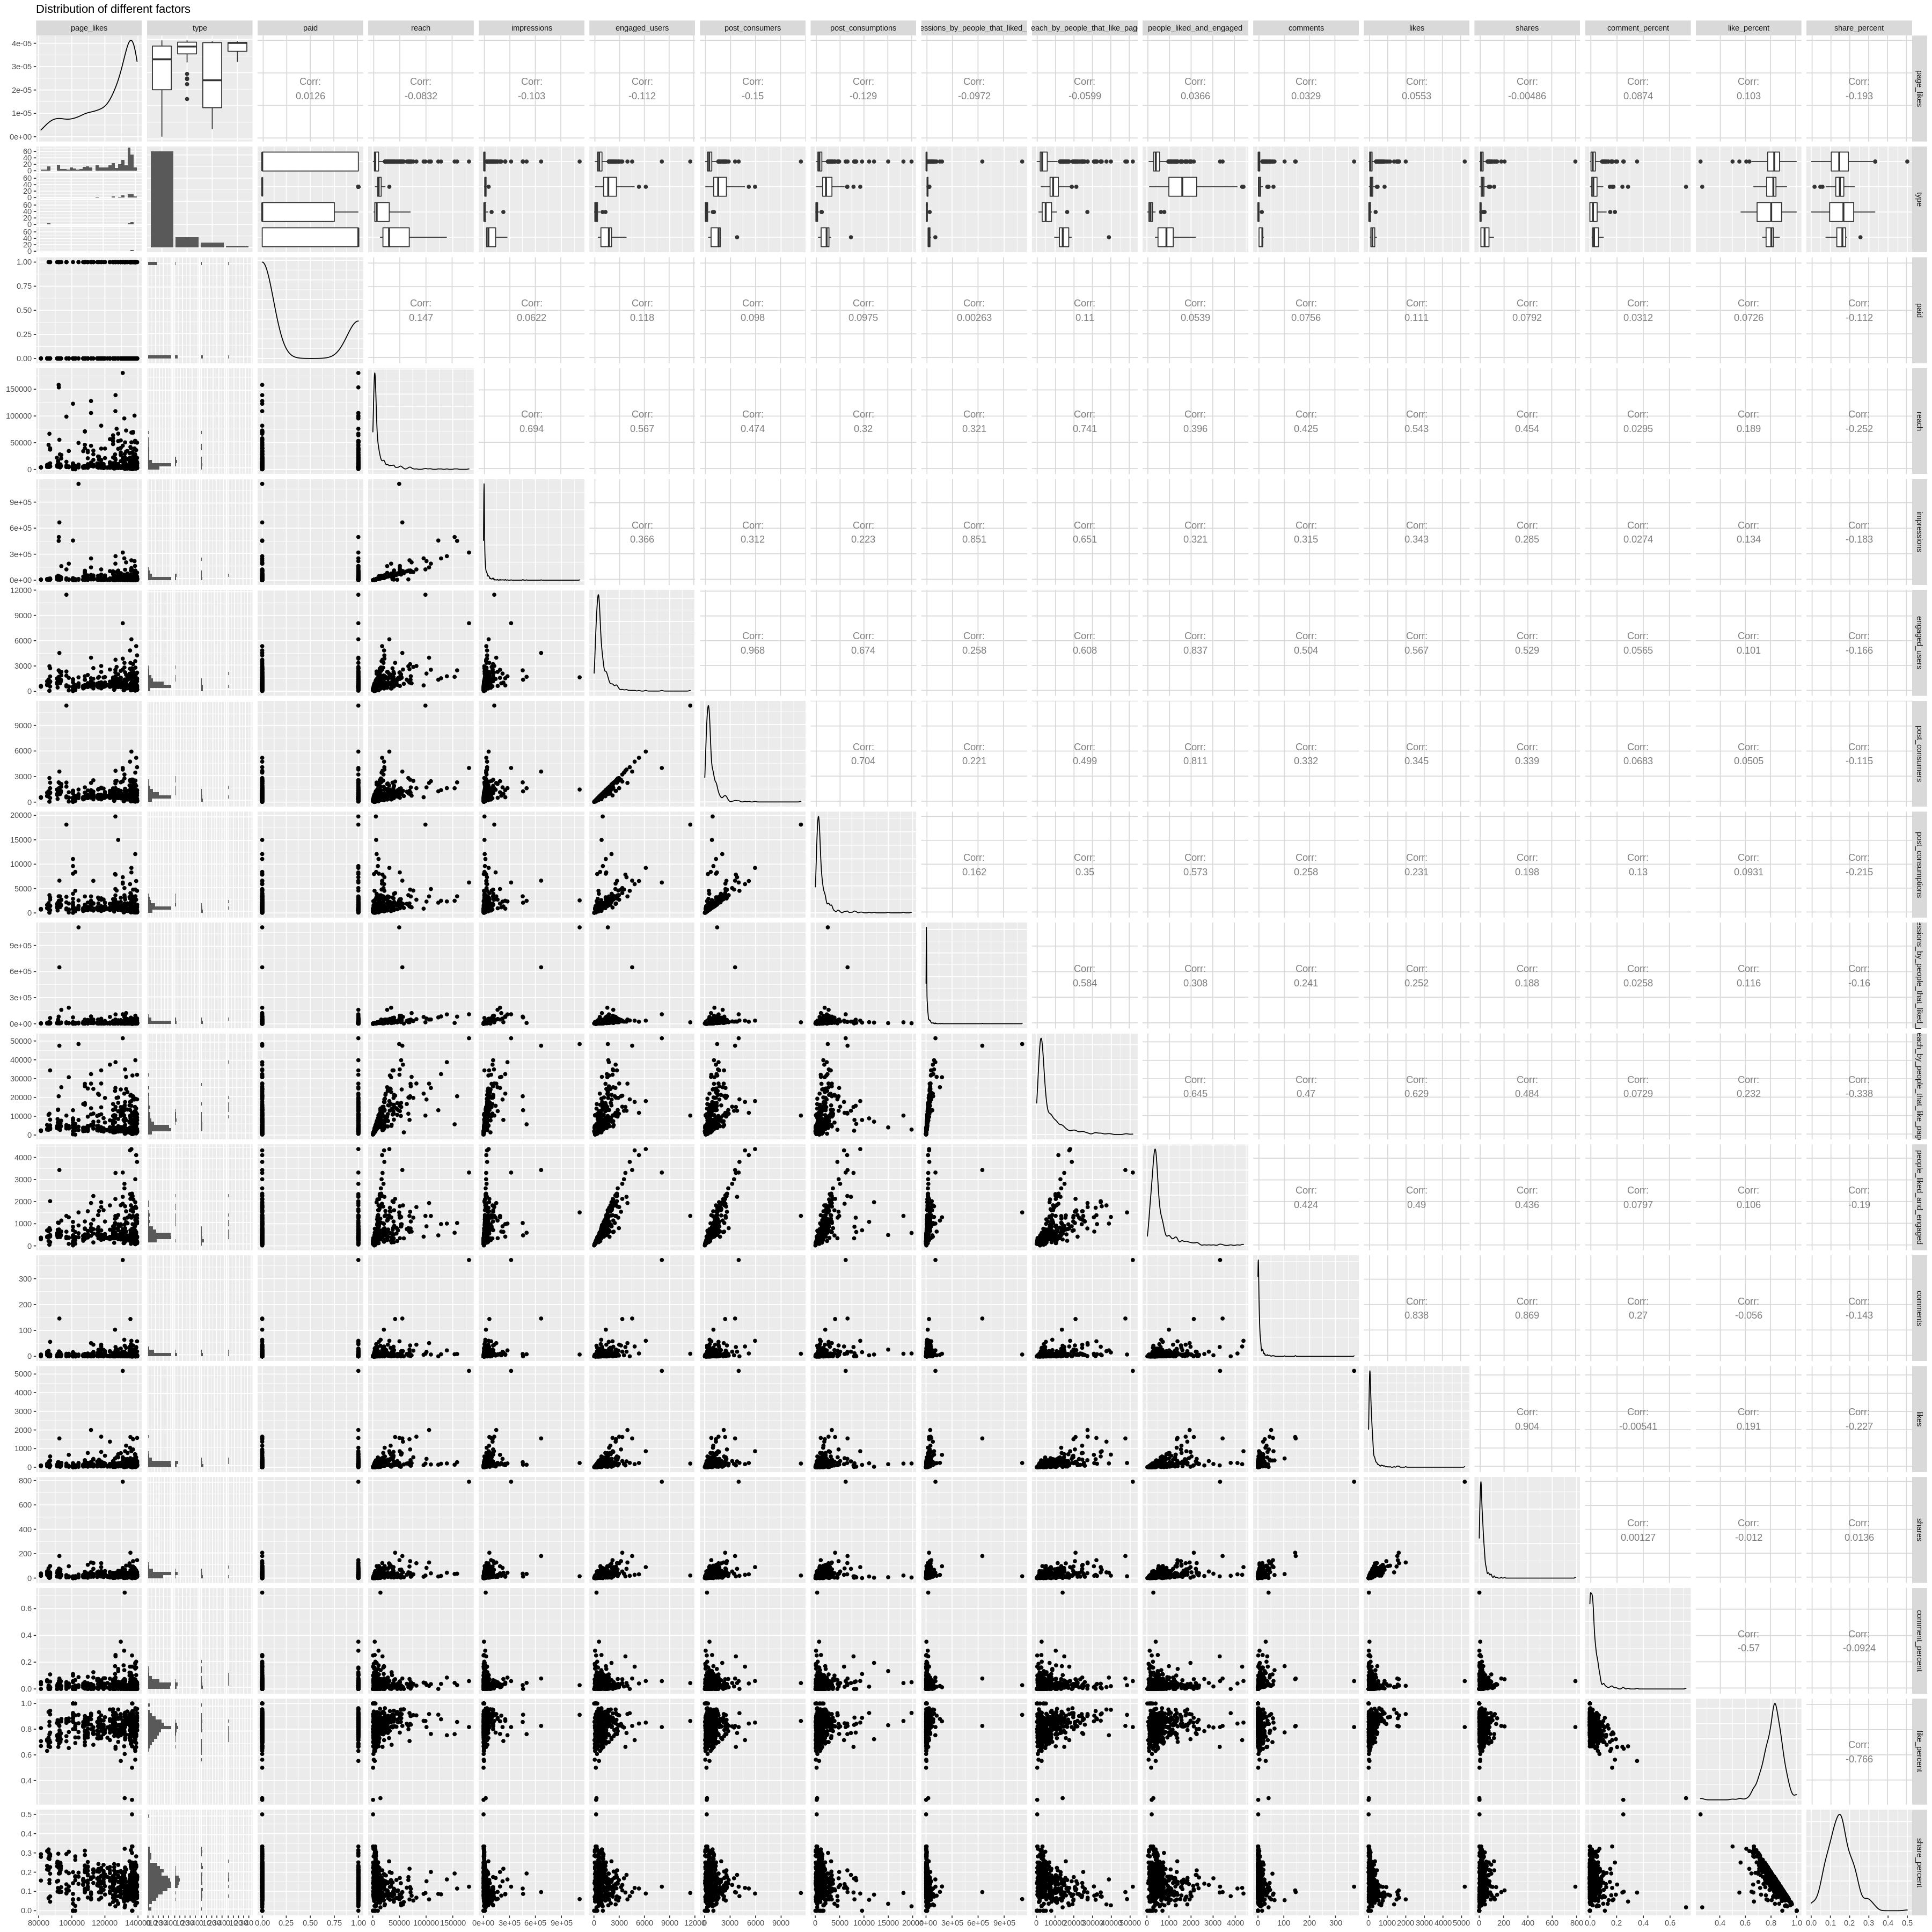

In [19]:
options(repr.plot.height = 30, repr.plot.width = 30)
fb_select_plot <- fb_data_selected %>% 
    ggpairs() +
    ggtitle("Distribution of different factors")
    theme(text = element_text(size=14))
plots <- lapply(1:fb_select_plot$ncol, function(j) getPlot(fb_select_plot, i = 2, j = j))
ggmatrix(
    plots,
    nrow = 1,
    ncol = pairs$ncol,
    xAxisLabels = pairs$xAxisLabels,
    yAxisLabels = primary_var
)
# fb_select_plot$nrow <- 1
# fb_select_plot$yAxisLabels <- fb_plot$yAxisLabels[2]
fb_select_plot

#### Methods:

Our analysis will use the following input columns of the original dataset: *Page total likes*, *Type*, *Category*, *Paid*, *comment*, *like*, *share*, and *Total Interactions*. Our aim is to use the K-nearest neighbours algorithm to generate a classification model which will classify a post by type (photo, status, link, or video). This will involve analyzing the key engagement metrics (comments, likes, and shares) and comparing their ratios of total interactions to examine how differences in engagement can be used to classify a post’s type. We will be using ratios instead of the raw values because the raw values are a measure of the popularity of the page, and not characteristics of the post type. This will normalize the data, allowing for the model to be effective in classifying posts for any page size. 

To visualize our results, we plan to use a confusion matrix. This will display how often our classification model labels a post correctly, and how often each label gets confused with another. We will also use bar charts to visualize relevant and intermediate results; e.g., we will create a bar chart with post type on the x-axis and interactions on the y-axis, filling out the bars with proportional values of the type of each interaction. As part of the tuning step of creating the model, we can create a line chart to show us the optimal K value. 

#### Expected outcomes and significance:

This analysis hopes to define a relationship between type of post (i.e., photo, status, link, or video) and ratio of the corresponding post’s interaction type. It is expected that videos and photos, for example, may have higher percentages of interactions that are comments and/or likes when compared to a link or status.

This classification application for labeling a post’s type could be helpful in identifying the types of reactions that a post might receive. It is possible that we find images get the most likes, while statuses get the most comments. Knowing how these metrics indicate the type could lead to better targeted ad campaigns that look for a certain type of user engagement.

Future questions following from this analysis may include:
- Do paid posts generate more traffic than unpaid posts?
- Does the category of a post (i.e., “action”, “product”, or “inspiration” classification) affect the overall and/or ratio of interactions on a post?
- Do posts with more interactions overall correlate with increases in users liking a company’s Facebook page? 

In examining the data for classification, it is also expected that trends may emerge which could in the future be used to predict post engagement. This predictive knowledge could be used by companies looking to grow their social media reach, as they may more accurately tailor their posts to yield higher engagement before publishing.

# USE STEP MUTATE TO APPLY PERCENTS TO THE MODEL

In [20]:
ups_recipe <- recipe(type ~ like_percent, data = fb_data) %>%
    step_upsample(type, over_ratio = 1, skip = FALSE) %>%
    
    step_rm(paid, category, post_month, post_weekday, post_hour) %>% 
    prep()

ups_recipe


ERROR: Error in parse(text = x, srcfile = src): <text>:1:44: unexpected ','
1: ups_recipe <- recipe(type ~ like_percent + ,
                                               ^


In [ ]:
upsample_fb <- bake(ups_recipe, fb_data)
upsample_fb

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 20)

fb_plot <- upsample_fb %>% 
    ggpairs() +
    theme(text = element_text(size=14))

## word count
